In [1]:
!pip install -U mplsoccer

  Attempting uninstall: mplsoccer
    Found existing installation: mplsoccer 1.5.0
    Uninstalling mplsoccer-1.5.0:
      Successfully uninstalled mplsoccer-1.5.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [3]:
#import dataset
parser = Sbopen()
df, related, freeze, tactics = parser.event(3869685)

Prepare Data

In [11]:
# Prepare data for both teams
teams = ['France', 'Argentina']
team_colors = {'France': 'red', 'Argentina': 'blue'}
scatter_dfs = {}
lines_dfs = {}

for team in teams:
    # Find first substitution for the team
    sub_idx = df.loc[(df['type_name'] == 'Substitution') & (df['team_name'] == team)].iloc[0]['index']
    # Successful passes before first sub
    mask = (df.type_name == 'Pass') & (df.team_name == team) & (df.index < sub_idx) & (df.outcome_name.isna())
    df_pass = df.loc[mask, ['x', 'y', 'end_x', 'end_y', 'player_name', 'pass_recipient_name']].copy()
    df_pass['player_name'] = df_pass['player_name'].apply(lambda x: str(x).split()[-1])
    df_pass['pass_recipient_name'] = df_pass['pass_recipient_name'].apply(lambda x: str(x).split()[-1])

    # Node locations and sizes
    scatter_df = pd.DataFrame()
    for i, name in enumerate(df_pass["player_name"].unique()):
        passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
        recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
        passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
        recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
        scatter_df.at[i, "player_name"] = name
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
    scatter_dfs[team] = scatter_df

    # Pass lines
    df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
    lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    lines_df = lines_df[lines_df['pass_count'] > 2]
    lines_dfs[team] = lines_df

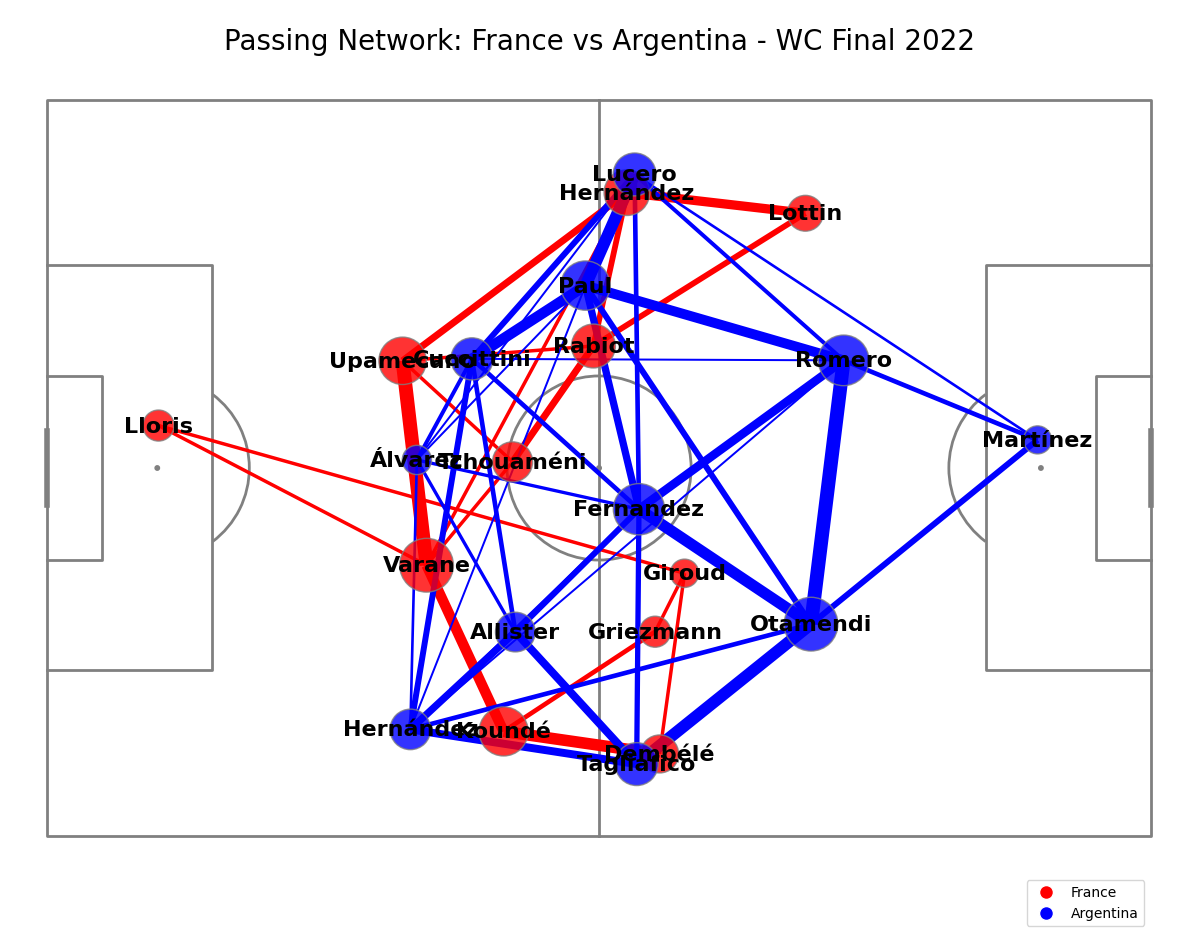

In [16]:
# Plot both teams
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

for team in teams:
    scatter_df = scatter_dfs[team]
    lines_df = lines_dfs[team]
    color = team_colors[team]
    # Flip Argentina's coordinates
    if team == 'Argentina':
        scatter_df = scatter_df.copy()
        scatter_df['x'] = 120 - scatter_df['x']
        scatter_df['y'] = 80 - scatter_df['y']
        lines_df = lines_df.copy()
    # Plot nodes
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=color, edgecolors='grey', linewidth=1, alpha=0.8, ax=ax["pitch"], zorder=3, label=team)
    for i, row in scatter_df.iterrows():
        pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)
    # Plot lines
    for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row["pair_key"].split("_")[1]
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=1, lw=line_width, zorder=2, color=color, ax=ax["pitch"])

fig.suptitle("Passing Network: France vs Argentina - WC Final 2022", fontsize=20)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='France', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Argentina', markerfacecolor='blue', markersize=10)],
           loc='upper right')
plt.show()

#save figure
fig.savefig('../data/imgs/passing_network_france_argentina.png', dpi=300, bbox_inches='tight')

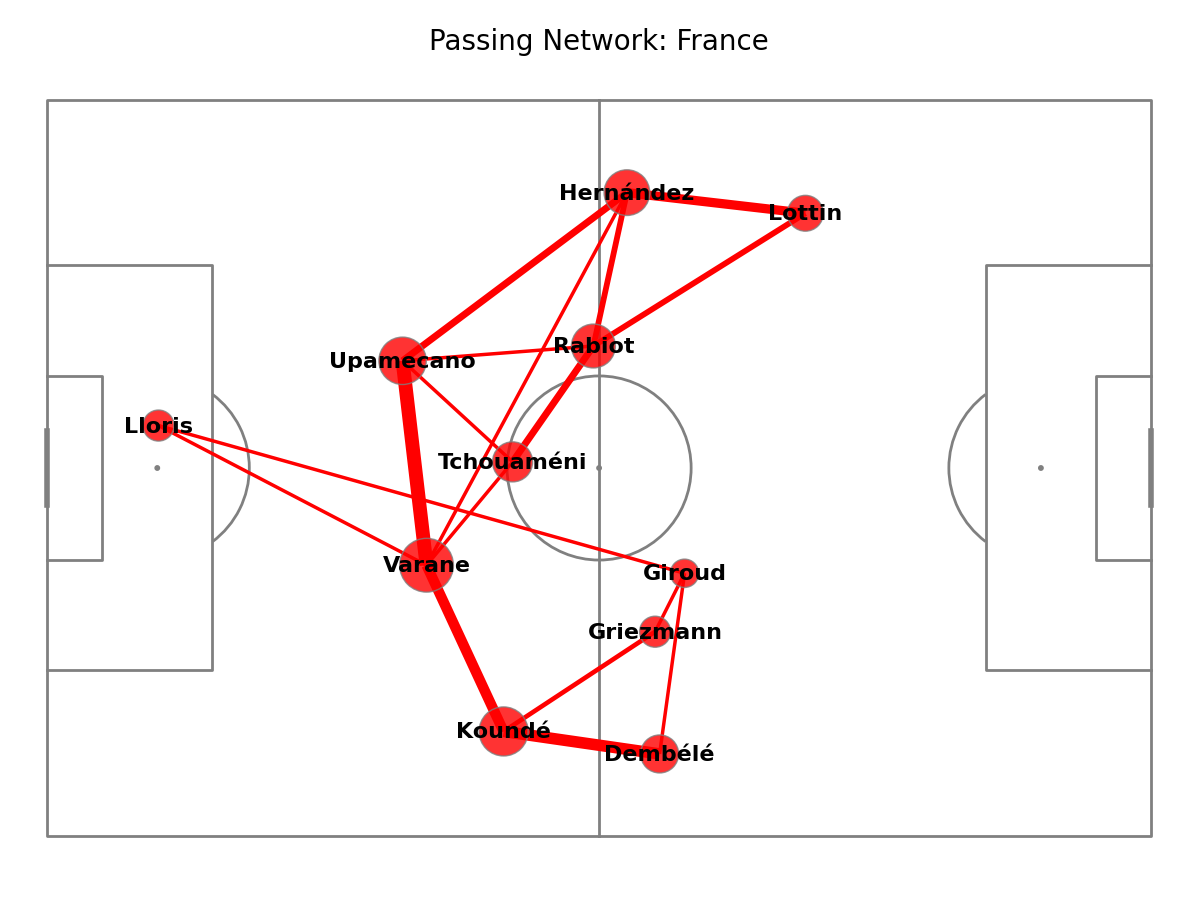

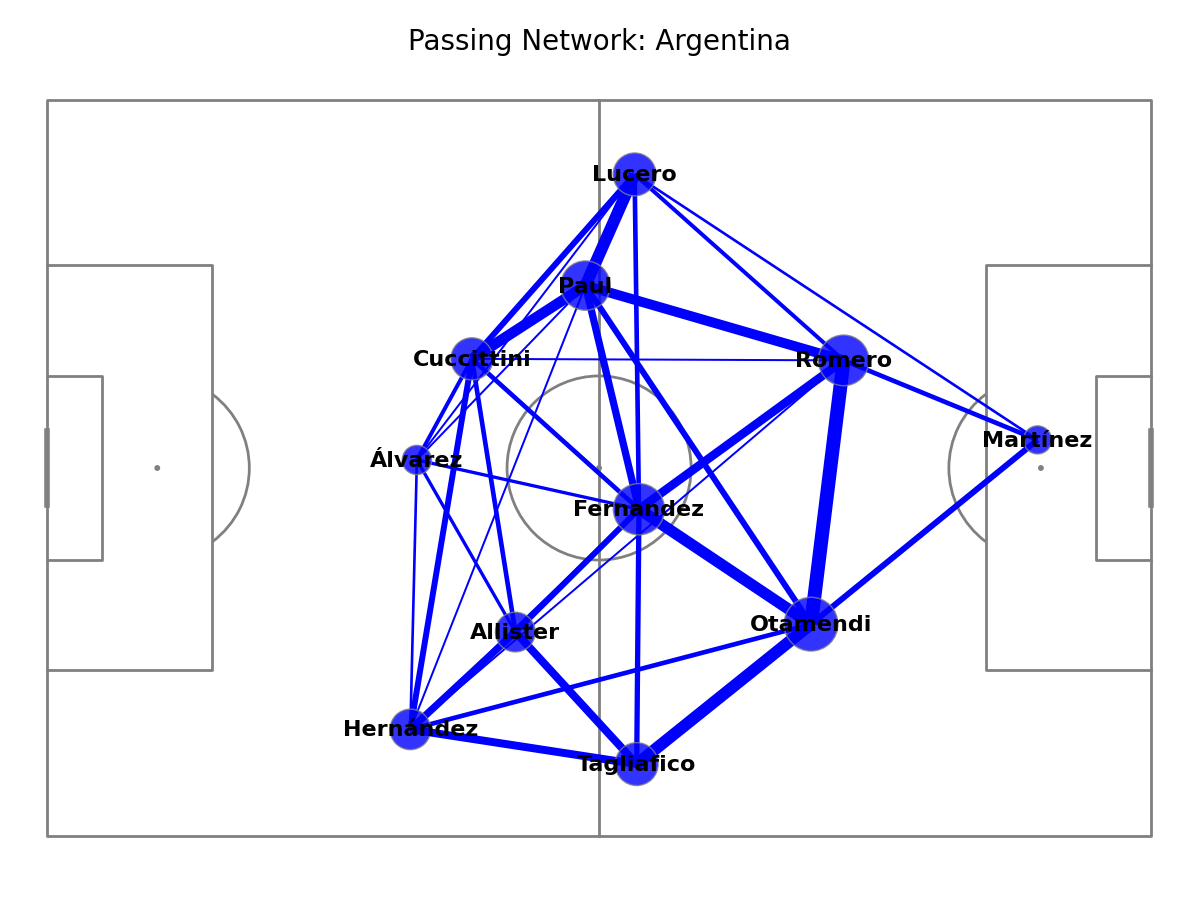

In [17]:
# --- Plot separated passing networks for each team ---
for team in teams:
    pitch = Pitch(line_color='grey')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    scatter_df = scatter_dfs[team]
    lines_df = lines_dfs[team]
    color = team_colors[team]
    # Flip Argentina's coordinates so both attack left-to-right
    if team == 'Argentina':
        scatter_df = scatter_df.copy()
        scatter_df['x'] = 120 - scatter_df['x']
        scatter_df['y'] = 80 - scatter_df['y']
        lines_df = lines_df.copy()
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=color, edgecolors='grey', linewidth=1, alpha=0.8, ax=ax["pitch"], zorder=3, label=team)
    for i, row in scatter_df.iterrows():
        pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)
    for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row["pair_key"].split("_")[1]
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=1, lw=line_width, zorder=2, color=color, ax=ax["pitch"])
    fig.suptitle(f"Passing Network: {team}", fontsize=20)
    plt.show()
    # Save each team's figure
    fig.savefig(f'../data/imgs/passing_network_{team.lower()}.png', dpi=300, bbox_inches='tight')